In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from simulation import  *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter
import torchvision
from torchvision import transforms

from SpykeTorch import snn
from SpykeTorch import functional as sf
from SpykeTorch import visualization as vis
from SpykeTorch import utils

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import matplotlib.cm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
length = 3    #length of the fixed input encoding
timesteps = 4 # Resolution for timesteps and weights
window_size = 2 #number of context words = 2* window_size
num_neurons = 10 # length of the final representation encoding
rf_size = window_size*2
inchannels = 1

simulation = Simulation()
corpus = Corpus()
sentences = simulation.construct_sentences()
tokens = corpus.tokenize(sentences)

# corpus.dictionary.get_encoding(length,timesteps)
corpus.dictionary.get_gaussian_encoding(42,length,timesteps,0.75)

spike_data = SpikeData(tokens, sentences, corpus)
spike_input, input, spike_output, output = spike_data.convert_tokens(window_size)

def plot_mesh(result):
    X = np.linspace(0, result.shape[1],result.shape[1])
    Y = np.linspace(0, result.shape[0],result.shape[0])
    X, Y = np.meshgrid(X, Y)

    plt.figure(figsize = (10,10))

    plt.contourf(X, Y, result, [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
    plt.colorbar(ticks=range(5))
    plt.ylabel("learning")
    plt.xlabel("feature")
    # ax.plot_surface(X,Y,result.numpy())
#     print(result.numpy().shape)
#     print(X.shape)

#     result[result<4] = 0
#     result[result==4] = 1
#     four = torch.sum(result, dim = 1)
#     print(torch.max(four))

idx2spike:  (42, 3)
idx2spike:  [[2. 0. 0.]
 [2. 1. 0.]
 [3. 2. 0.]
 [2. 0. 0.]
 [3. 2. 0.]
 [3. 1. 0.]
 [2. 0. 0.]
 [3. 1. 0.]
 [3. 2. 0.]
 [2. 0. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [3. 2. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [2. 0. 0.]
 [3. 1. 0.]
 [3. 2. 0.]
 [3. 2. 0.]
 [2. 1. 0.]
 [2. 0. 0.]
 [2. 1. 0.]
 [2. 1. 0.]
 [2. 1. 0.]
 [3. 2. 0.]
 [3. 2. 0.]
 [3. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [3. 1. 0.]
 [3. 2. 0.]
 [3. 1. 0.]
 [2. 1. 0.]
 [3. 1. 0.]
 [2. 0. 0.]
 [2. 0. 0.]]


In [13]:
#possibly don't need this if using Gaussian encoding
spike_input = np.array([np.hstack((s,3-s)) for s in spike_input])
length = 6

In [21]:
print(spike_input.shape)
print(corpus.dictionary.idx2word[output[7]])
print(input[1])

(34608, 4, 3)
the
[0 1 3 4]


In [ ]:
### Column Initialization ###
from columns import Column1, Column, SynDataset

voc_size = len(corpus.dictionary.idx2word) #vocabulary size: number of unique words
kwta1 = int(num_neurons/2)                   # maximum number of firing neurons for each column of the first layer
kwta2 = 8          # maximum number of firing neurons for the second layer
threshold1 = 8 # Firing threshold for the first layer columns
threshold2 = 8 # Firing threshold for the second layer 


column1 = Column1(num_neurons, threshold1, kwta1, 0, rf_size, length, timesteps)
column2 = Column(num_neurons, threshold2, kwta2,0,rf_size,num_neurons, timesteps)
dataset = SynDataset(corpus,spike_input, input,  output, timesteps, ['dog','cat','sits']) 

#zero-initialize the learned representation 
#the learned representation for word with index i: R[:, :, i] with size (timesteps x length of the final encoding) -->{0,1}
R = torch.zeros((timesteps, num_neurons, voc_size))


In [18]:
# input_temp, input_r,  output_r = dataset.__getitem__(1)
# print(input_temp.size())
# print(R[:,:,input_r].size())
# out = column1(input_temp, R[:,:,input_r])
# print(out.size())
# out2 = column2(out)
# print(out2.size())
# column2.rstdp(out, out2, R[:,:,output_r])
# R[:,:,output_r] = out2.squeeze()


In [19]:
from SpykeTorch import snn
from columns import train_rstdp

num_epochs = 5

result, result_label, R1 = train_rstdp(dataset, column1, column2, num_neurons, num_epochs, R)

  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

[ 2.  3. 31.]
tensor([[2., 3., 1.],
        [0., 0., 0.],
        [2., 3., 1.],
        [2., 3., 1.],
        [2., 3., 1.],
        [2., 3., 1.],
        [2., 3., 1.],
        [0., 0., 0.],
        [2., 3., 1.],
        [2., 3., 1.]])
(2640, 10)


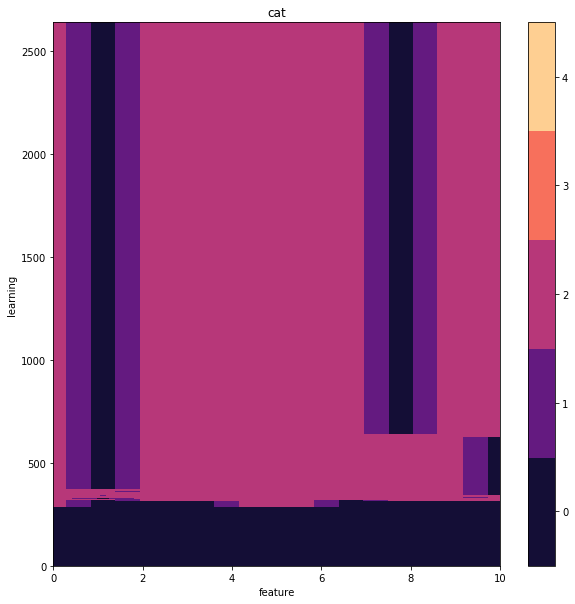

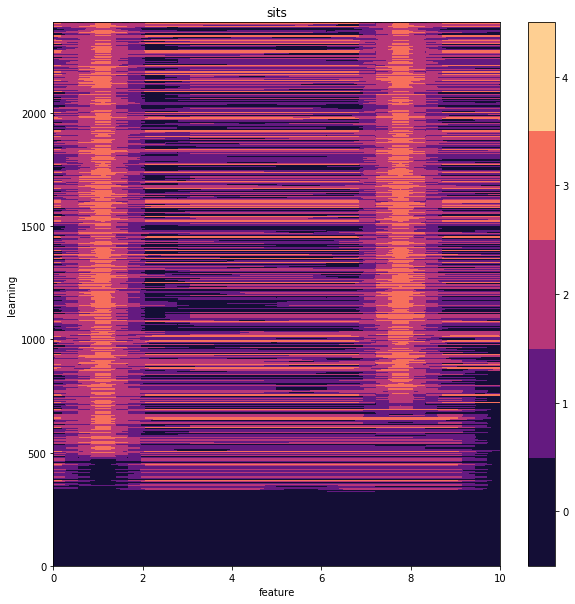

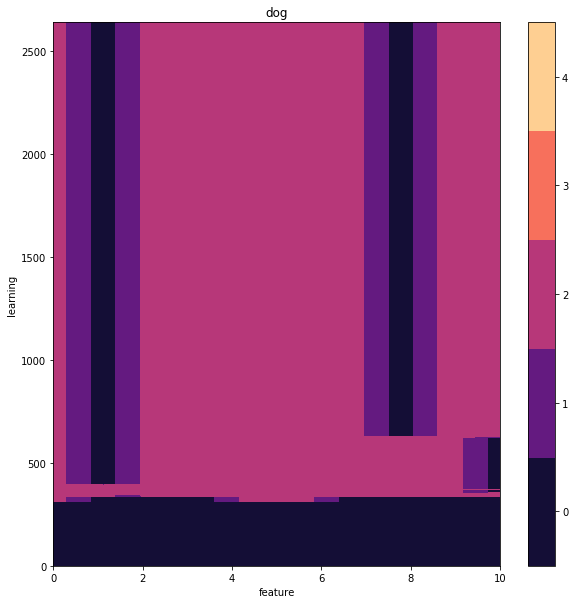

In [8]:
labels = np.unique(result_label)
print(labels) # print all the indexes of the center words presented in the training
print(torch.sum(R1, dim=0)[:,labels]) # print the learned representation of those center words
print(result[result_label==labels[0],:].shape) 
for l in labels:
    plot_mesh(result[result_label==l,:]) #plot how the representation of the center words evolve over training
    plt.title(corpus.dictionary.idx2word[int(l)])
    plt.show()

In [ ]:
result, result_label, R2 = train_rstdp(dataset, column1, column2, num_neurons, num_epochs, R1)

  0%|          | 0/1 [00:00<?, ?it/s]

[ 2.  3. 31.]
tensor([[2., 0., 2.],
        [2., 0., 2.],
        [2., 0., 2.],
        [2., 0., 2.],
        [0., 3., 0.],
        [2., 0., 2.],
        [2., 0., 2.],
        [2., 0., 2.],
        [2., 0., 2.],
        [0., 3., 0.]])
(2640, 10)


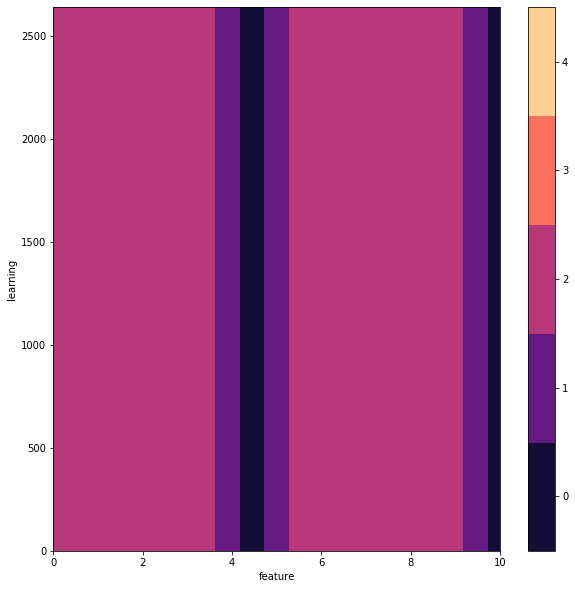

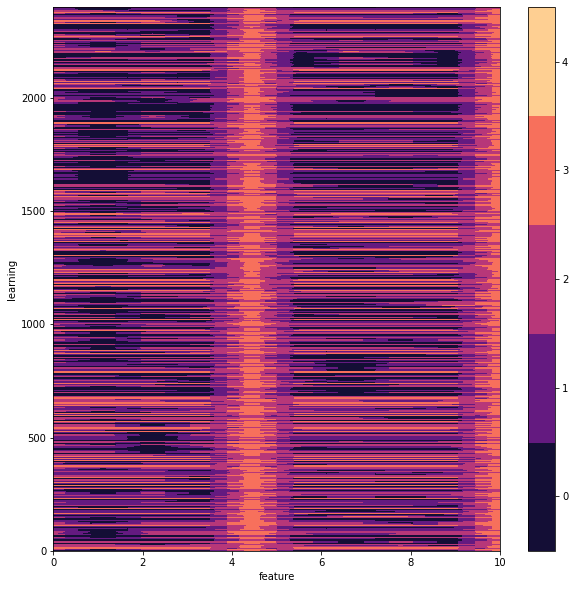

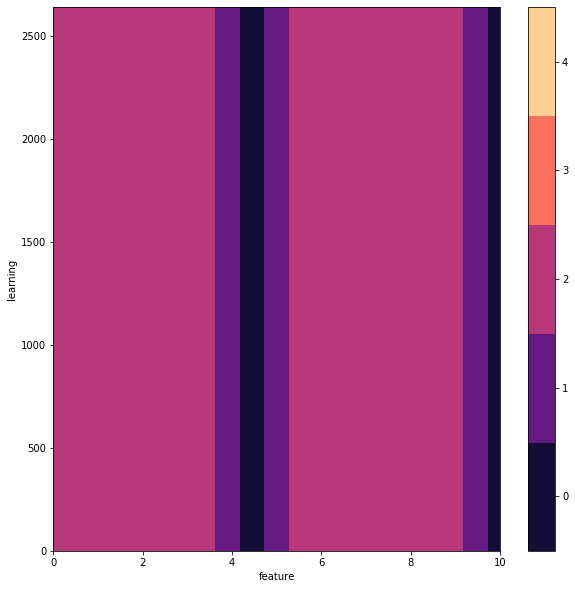

In [30]:
labels = np.unique(result_label)
print(labels)
print(torch.sum(R1, dim=0)[:,labels])
print(result[result_label==labels[0],:].shape)
for l in labels:
    plot_mesh(result[result_label==l,:])
    plt.show()

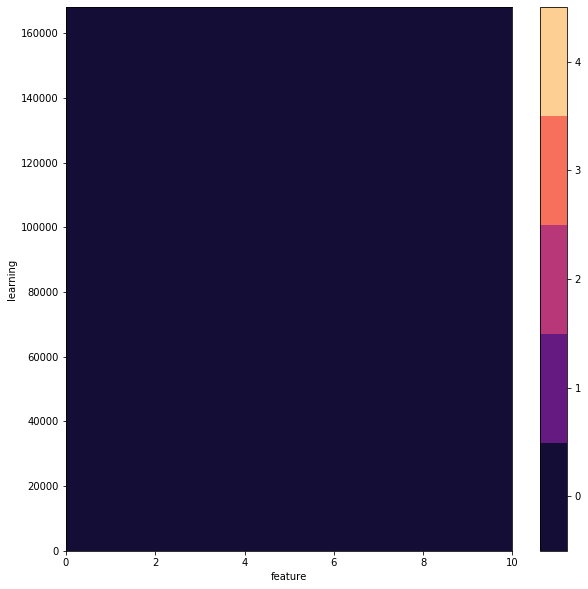

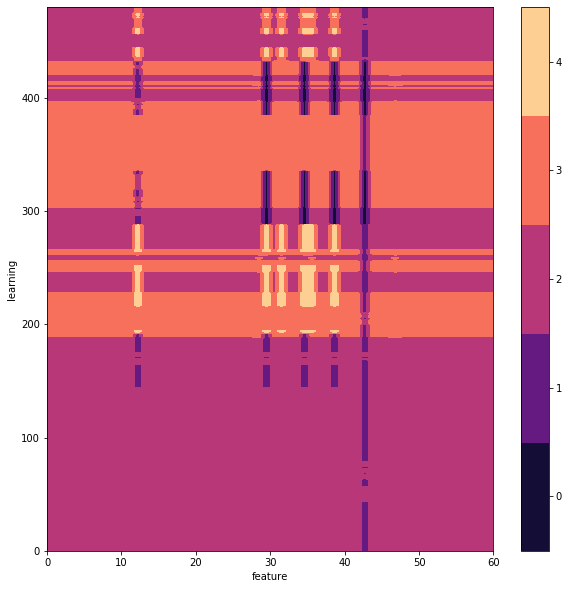

In [179]:
plot_mesh(test_result[:480,:])

In [38]:

### Column Initialization ###

MyColumn2 = Column(num_neurons, threshold, 8, 0)

    
dog = DatasetContext(sit_context)
trainLoader = DataLoader(dog, batch_size=1000, shuffle=True)

num_epochs = 15
result2 = torch.zeros(num_epochs*dog.__len__(), num_neurons)
for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader):
        for i in range(len(data)):
            out = MyColumn2(data[i])
            result2[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn2.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.0010170936584473


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.1255838871002197


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.9129364490509033


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.9335274696350098


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.1220498085021973


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.986626148223877


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.9880578517913818


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  0.8989684581756592


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.239969253540039


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.2384588718414307


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.5972001552581787


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.5579774379730225


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.6027183532714844


  0%|          | 0/1 [00:00<?, ?it/s]

Training done under  1.649308443069458


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

Training done under  1.4293889999389648


(7200, 60)
[4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 4. 0. 4. 4. 0. 0. 0. 0. 0. 4. 4. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0.
 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


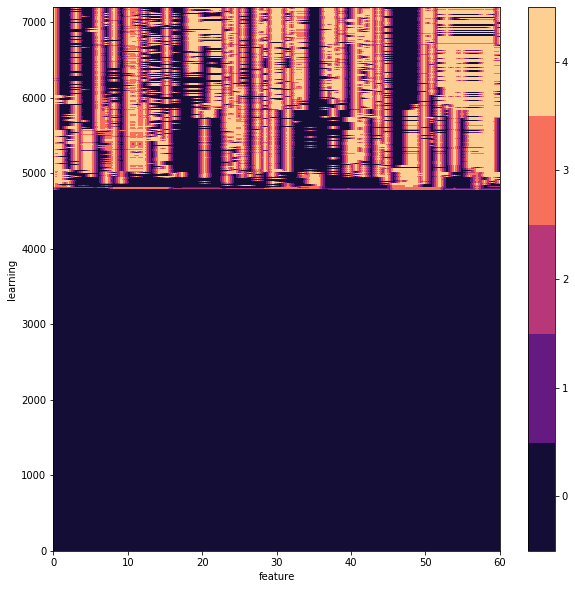

In [39]:
X = np.linspace(0, result2.size(1),result2.size(1))
Y = np.linspace(0, result2.size(0),result2.size(0))
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,10))

plt.contourf(X, Y, result2.numpy(), [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")
# ax.plot_surface(X,Y,result.numpy())
print(result2.numpy().shape)
print(result2.numpy()[-1,:])


In [40]:
print(result2.numpy()[-2,:])
print(result2.numpy()[-3,:])
print(result2.numpy()[-4,:])

print(result2.numpy()[0,:])


[3. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 4. 0. 0. 0. 0.
 0. 4. 4. 0. 0. 0. 0. 0. 0. 4. 0. 4.]
[3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 3. 0. 3. 3. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 3. 0. 3. 0. 0. 0. 0. 0. 0. 0.]
[4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 4. 4. 4. 4. 4. 4. 4. 4. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [41]:
temporal_transform = utils.Intensity2Latency(timesteps)

### Column Initialization ###

MyColumn = Column(num_neurons, threshold, 8, 0)
    
cat = DatasetContext(cat_context)
sit = DatasetContext(sit_context)

trainLoader1 = DataLoader(cat, shuffle=True)
trainLoader2 = DataLoader(sit, shuffle = True)

num_epochs = 20
result1 = torch.zeros(num_epochs*(cat.__len__()), num_neurons)
result2 = torch.zeros(num_epochs*(sit.__len__()), num_neurons)
result3 = torch.zeros(num_epochs*(cat.__len__()), num_neurons)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader1):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result1[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader2):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result2[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

for epochs in range(num_epochs):
    start = time.time()
    cnt = 0
    for data in tqdm(trainLoader1):
        for i in range(len(data)):
            out = MyColumn(data[i])
            result3[epochs*480+i, :] = torch.sum(out.squeeze(),dim=0)
            MyColumn.stdp(data[i],out)
    end = time.time()
    print("Training done under ", end-start)

  8%|▊         | 38/480 [00:00<00:01, 378.16it/s]

Training done under  1.1821651458740234


  8%|▊         | 38/480 [00:00<00:01, 378.76it/s]

Training done under  1.2808358669281006


  8%|▊         | 39/480 [00:00<00:01, 382.79it/s]

Training done under  1.2834537029266357


 11%|█         | 52/480 [00:00<00:00, 515.04it/s]

Training done under  1.1572041511535645


  8%|▊         | 38/480 [00:00<00:01, 373.16it/s]

Training done under  0.9891338348388672


 11%|█         | 51/480 [00:00<00:00, 501.30it/s]

Training done under  1.0532972812652588


 10%|█         | 50/480 [00:00<00:00, 492.57it/s]

Training done under  1.2752106189727783


  8%|▊         | 38/480 [00:00<00:01, 374.19it/s]

Training done under  0.9405341148376465


 11%|█         | 52/480 [00:00<00:00, 519.42it/s]

Training done under  1.1766643524169922


  8%|▊         | 38/480 [00:00<00:01, 373.64it/s]

Training done under  1.1618561744689941


 11%|█         | 53/480 [00:00<00:00, 527.77it/s]

Training done under  1.0440468788146973


  7%|▋         | 34/480 [00:00<00:01, 339.15it/s]

Training done under  1.1722686290740967


  8%|▊         | 37/480 [00:00<00:01, 369.38it/s]

Training done under  1.4049832820892334


 11%|█         | 52/480 [00:00<00:00, 518.51it/s]

Training done under  1.1911976337432861


  8%|▊         | 38/480 [00:00<00:01, 377.37it/s]

Training done under  0.9604771137237549


  8%|▊         | 38/480 [00:00<00:01, 378.75it/s]

Training done under  1.2799501419067383


 10%|█         | 50/480 [00:00<00:00, 498.91it/s]

Training done under  1.1182022094726562


  6%|▋         | 30/480 [00:00<00:01, 291.03it/s]

Training done under  1.1997125148773193


  9%|▊         | 41/480 [00:00<00:01, 407.56it/s]

Training done under  1.6041641235351562


  6%|▋         | 30/480 [00:00<00:01, 295.17it/s]

Training done under  1.4996075630187988


  8%|▊         | 40/480 [00:00<00:01, 398.13it/s]

Training done under  1.3771867752075195


  7%|▋         | 34/480 [00:00<00:01, 331.22it/s]

Training done under  1.2889471054077148


  8%|▊         | 40/480 [00:00<00:01, 392.91it/s]

Training done under  1.2865149974822998


  6%|▌         | 28/480 [00:00<00:01, 274.05it/s]

Training done under  1.5935311317443848


  6%|▌         | 28/480 [00:00<00:01, 278.96it/s]

Training done under  1.7534246444702148


  8%|▊         | 39/480 [00:00<00:01, 388.49it/s]

Training done under  1.4747915267944336


  6%|▋         | 30/480 [00:00<00:01, 293.06it/s]

Training done under  1.5289945602416992


  6%|▌         | 29/480 [00:00<00:01, 288.04it/s]

Training done under  1.6647248268127441


  6%|▋         | 30/480 [00:00<00:01, 291.92it/s]

Training done under  1.6603293418884277


  7%|▋         | 35/480 [00:00<00:01, 349.66it/s]

Training done under  1.3906540870666504


  9%|▊         | 41/480 [00:00<00:01, 408.62it/s]

Training done under  1.2838711738586426


  6%|▋         | 30/480 [00:00<00:01, 292.63it/s]

Training done under  1.321561336517334


  6%|▋         | 30/480 [00:00<00:01, 292.29it/s]

Training done under  1.6592090129852295


  6%|▋         | 30/480 [00:00<00:01, 292.85it/s]

Training done under  1.6564652919769287


  6%|▋         | 30/480 [00:00<00:01, 292.37it/s]

Training done under  1.6640784740447998


  6%|▌         | 28/480 [00:00<00:01, 277.18it/s]

Training done under  1.6595537662506104


  6%|▋         | 30/480 [00:00<00:01, 295.98it/s]

Training done under  1.4802260398864746


  5%|▌         | 25/480 [00:00<00:01, 245.50it/s]

Training done under  1.8428237438201904


  6%|▋         | 30/480 [00:00<00:01, 293.05it/s]

Training done under  1.6396069526672363


  6%|▋         | 30/480 [00:00<00:01, 293.20it/s]

Training done under  1.665393352508545


  6%|▋         | 30/480 [00:00<00:01, 295.13it/s]

Training done under  1.6448209285736084


  6%|▋         | 30/480 [00:00<00:01, 294.36it/s]

Training done under  1.643270492553711


  9%|▉         | 42/480 [00:00<00:01, 410.37it/s]

Training done under  1.6202876567840576


  9%|▊         | 41/480 [00:00<00:01, 409.08it/s]

Training done under  1.3565151691436768


  6%|▋         | 30/480 [00:00<00:01, 292.27it/s]

Training done under  1.4617643356323242


  6%|▋         | 30/480 [00:00<00:01, 292.03it/s]

Training done under  1.6537165641784668


  9%|▊         | 41/480 [00:00<00:01, 402.10it/s]

Training done under  1.3222079277038574


  6%|▋         | 30/480 [00:00<00:01, 295.15it/s]

Training done under  1.3178369998931885


  9%|▊         | 41/480 [00:00<00:01, 400.83it/s]

Training done under  1.4629018306732178


  8%|▊         | 40/480 [00:00<00:01, 397.40it/s]

Training done under  1.240978717803955


  8%|▊         | 37/480 [00:00<00:01, 369.86it/s]

Training done under  1.3179669380187988


  6%|▋         | 30/480 [00:00<00:01, 290.62it/s]

Training done under  1.698314905166626


  4%|▍         | 21/480 [00:00<00:02, 197.35it/s]

Training done under  1.673614263534546


  6%|▋         | 30/480 [00:00<00:01, 292.65it/s]

Training done under  1.7847352027893066


  6%|▋         | 30/480 [00:00<00:01, 294.22it/s]

Training done under  1.649308204650879


  6%|▌         | 29/480 [00:00<00:01, 288.96it/s]

Training done under  1.6551570892333984


  6%|▋         | 30/480 [00:00<00:01, 292.59it/s]

Training done under  1.5381510257720947


  6%|▋         | 30/480 [00:00<00:01, 292.40it/s]

Training done under  1.6527736186981201


  6%|▌         | 29/480 [00:00<00:01, 288.85it/s]

Training done under  1.6507515907287598


100%|██████████| 480/480 [00:01<00:00, 289.87it/s]

Training done under  1.6581933498382568


(28800, 60)


Text(0.5, 0, 'feature')

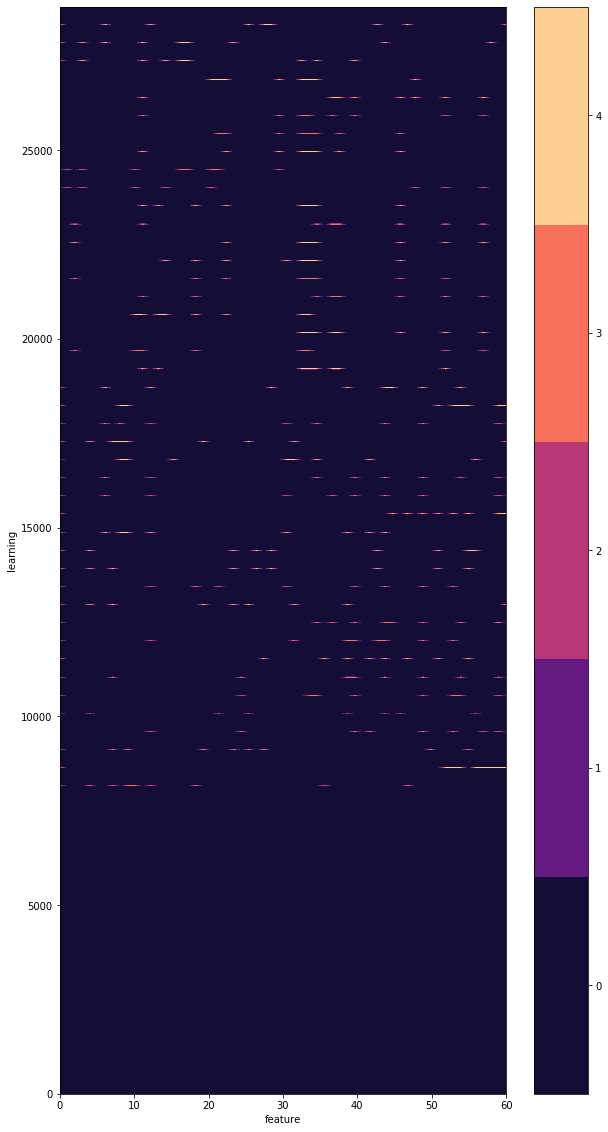

In [42]:
Z = np.concatenate((result1.numpy(), result2.numpy(), result3.numpy()), axis=0)
print(Z.shape)
X = np.linspace(0, Z.shape[1],Z.shape[1])
Y = np.linspace(0, Z.shape[0],Z.shape[0])
X, Y = np.meshgrid(X, Y)

plt.figure(figsize = (10,20))

plt.contourf(X, Y, Z, [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], cmap='magma')
plt.colorbar(ticks=range(5))
plt.ylabel("learning")
plt.xlabel("feature")